<a href="https://colab.research.google.com/github/srishtipithadia/ProjectsInMLandAI/blob/main/HW4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
**Homework 4: Sequence Models**

*   By: Srishti Pithadia
*   Date: October 21st, 2022


---


**Task 0: General Set Up**

In [1]:
# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout, Masking, Embedding
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
import warnings
warnings.filterwarnings("ignore")

a. Describe the Problem

The problem I want to investigate is if there's a trend in the number of COVID cases in NY over time. I want to see if it's possible to make a prediction about future COVID case rates, since that is relevant and useful knowledge. This data is based off of date, county (in the US), state (in the US), FIPS (like a zip-code but specific to a certain county- may vary in metro areas), cases, and deaths. While these colums are for all of the US, I only want to examine counties in NY.

b. Pick the Dataset

In [2]:
#link: https://www.kaggle.com/datasets/fireballbyedimyrnmom/us-counties-covid-19-dataset 
df = pd.read_csv('us-counties.csv', parse_dates=["date"])

# viewing the first few rows of the data
df = df[df.state == 'New York']
df.head()

,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,NaN,1,0.0
448,2020-03-02,New York City,New York,NaN,1,0.0
482,2020-03-03,New York City,New York,NaN,2,0.0
518,2020-03-04,New York City,New York,NaN,2,0.0
519,2020-03-04,Westchester,New York,36119.0,9,0.0


In [3]:
# seeing the size of the data
df.shape

(45692, 6)

In [4]:
# seeing the type of the values in each feature column... need date to be datetime64[ns]
df.dtypes

date      datetime64[ns]
county            object
state             object
fips             float64
cases              int64
deaths           float64
dtype: object

This is a good dataset to address the problem identified above because the data pertains directly to the problem. It's appropriate for a Neural Network because it has many data points (45,692) and a decent amount of input features (6) as shown above, so it's at least somewhat complex. Additionally, the accuracy of predictions is a priority, where speed/explainability isn't necessarily. This dataset is also appropriate for a Sequence Model specifically because it's a time-series that starts from the first case recorded in the US (in late January 2020). This is important because we want to find a trend over time, and so the sequence of the data (by date) does matter. It is especially nice that it starts from the first case as well.

c. Pick the Framework

The framework I selected was Tensorflow, since it is the most commonly used framework for Neural Networks (via Keras). I can create a model with a specific set of input nodes, add output layers to the model, set up activation functions for each layer, and implement hyperparameter tuning (as done in HW3). For a Recurrent Neural Network specifically, this is a good option as well, because there are packages that make it easy to implement. Documentation for the relevant ones are listed below:

https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Masking

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

d. Exploratory Data Analysis

In [5]:
# getting general info about the dataset's columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45692 entries, 416 to 2501484
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    45692 non-null  datetime64[ns]
 1   county  45692 non-null  object        
 2   state   45692 non-null  object        
 3   fips    44878 non-null  float64       
 4   cases   45692 non-null  int64         
 5   deaths  45692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 2.4+ MB


In [6]:
# looking at the stats of the dataset's numerical columns
df.describe()

,fips,cases,deaths
count,44878.000000,4.569200e+04,45692.000000
mean,36062.574580,3.383734e+04,787.377024
std,36.277877,1.544977e+05,3965.197170
min,36001.000000,0.000000e+00,0.000000
25%,36031.000000,8.190000e+02,19.000000
50%,36063.000000,4.593500e+03,81.000000
75%,36095.000000,1.402100e+04,186.000000
max,36123.000000,2.422658e+06,40267.000000


In [7]:
# looking at stats of the dataset's categorical columns
df.describe(include=['O'])

,county,state
count,45692,45692
unique,59,1
top,New York City,New York
freq,804,45692


In [8]:
# checking to see if there are any missing vals in the dataset
df.isnull().sum()

date        0
county      0
state       0
fips      814
cases       0
deaths      0
dtype: int64

In [9]:
# dropping fips column because:
#          1. it doesn't apply in cities so there's many N/A values
#          2. we already have state and county, so we don't need county codes
df.drop(['fips'], axis=1, inplace=True)

# dropping deaths because I'm only looking at cases
df.drop(['deaths'], axis=1, inplace=True)

# dropping state because I know it's NY for all data (since filtered from beginning)
df.drop(['state'], axis=1, inplace=True)

# removed all rows from dataframe that have N/A or Unknown
df = df[df.county != 'Unknown']

print(df.shape)
print()
df.isnull().sum()

# shape is still large so dataset is still appropriate to use with RNN

(45682, 3)



date      0
county    0
cases     0
dtype: int64

In [10]:
# seeing if the data imbalanced
df.county.value_counts(normalize=True) #normalizes the result

New York City    0.017600
Westchester      0.017534
Nassau           0.017512
Rockland         0.017490
Saratoga         0.017469
Suffolk          0.017447
Ulster           0.017447
Monroe           0.017381
Albany           0.017359
Delaware         0.017359
Dutchess         0.017359
Herkimer         0.017359
Orange           0.017359
Schenectady      0.017337
Tompkins         0.017315
Tioga            0.017315
Broome           0.017315
Erie             0.017293
Greene           0.017293
Montgomery       0.017293
Putnam           0.017293
Allegany         0.017272
Onondaga         0.017272
Ontario          0.017272
Clinton          0.017250
Rensselaer       0.017250
Sullivan         0.017250
Wyoming          0.017250
Livingston       0.017228
Washington       0.017228
Warren           0.017228
Essex            0.017228
Jefferson        0.017228
Chenango         0.017228
Hamilton         0.017228
Schoharie        0.017206
Wayne            0.017206
Columbia         0.017184
Fulton      

In [11]:
# total cases/deaths for every recorded county in NY
df[['county', 'cases']].groupby(['county'], as_index=False).mean().sort_values(by='cases', ascending=False)

,county,cases
28,New York City,881233.130597
47,Suffolk,178864.499373
27,Nassau,165697.618750
55,Westchester,112003.209738
13,Erie,79872.629114
25,Monroe,59590.598237
33,Orange,43923.920555
39,Rockland,41622.782228
31,Onondaga,39026.395437
12,Dutchess,25746.345523


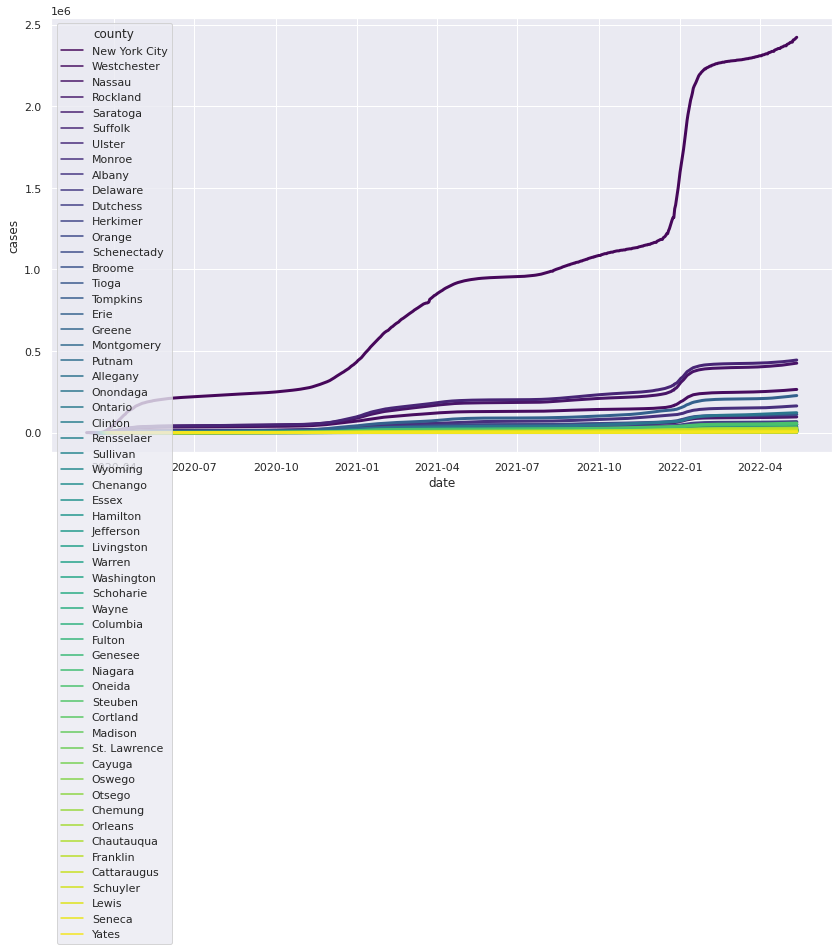

In [12]:
# graph of cases for every recorded county in NY over time
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=df, x ='date', y = 'cases',
                  hue='county', palette='viridis',
                  legend='full', lw=3)

plt.ylabel('cases')
plt.xlabel('date')
plt.show()

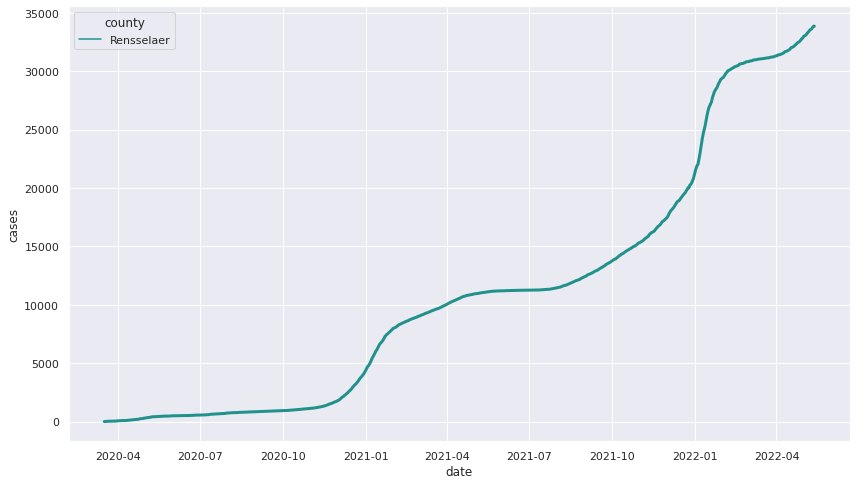

In [13]:
# graph of cases in our county over time
rpi_df = df[df.county == 'Rensselaer']

ax = sns.lineplot(data=rpi_df, x ='date', y = 'cases',
                  hue='county', palette='viridis',
                  legend='full', lw=3)
plt.show()

**Part 1: Implementing RNN**

a. Partitioning & Reshaping

In [14]:
# partitions and shapes inputted dataset
def prep(train_size, time_step, d_set):
  X, y = [], []

  # converts dates to datetime objects
  d_set['date'] = pd.to_datetime(d_set['date']) 
  
  # reshapes and scales as appropriate
  ds_shaped = np.reshape(d_set.cases.values, (-1,1))
  ds_scaled = scaler.fit_transform(ds_shaped)

  for i in range(time_step, train_size):
      X.append(ds_scaled[i-time_step:i,0])
      y.append(ds_scaled[i,0])

  X, y = np.array(X), np.array(y)

  # need X set to be (n_samples x timesteps x n_features)
  X = np.reshape(X, (X.shape[0], X.shape[1],1))
  y = np.reshape(y, (y.shape[0],1))

  return X, y

In [15]:
# initialize necessary params
train_size = round(df.shape[0] * .8)  
test_size = df.shape[0] - train_size
scaler = MinMaxScaler(feature_range = (0,1))

# get training data
X_train, y_train = prep(train_size, 1, df[:train_size].iloc[:,:3]) #train
print("Shape of X_train : ",X_train.shape)
print("Shape of y_train : ",y_train.shape)

# get testing data
X_test, y_test = prep(test_size, 1, df[train_size:].iloc[:,:3]) #test
print("\nShape of X_train : ",X_test.shape)
print("Shape of y_train : ",y_test.shape)

Shape of X_train :  (36545, 1, 1)
Shape of y_train :  (36545, 1)

Shape of X_train :  (9135, 1, 1)
Shape of y_train :  (9135, 1)


b. Implementing RNN

In [16]:
# Implementation of simple RNN
def make_rnn(X, Y, v):
    # initializing RNN
    model = Sequential()

    # first and second RNN layer (v changes whether RNN is SimpleRNN, LSTM, or GRU)
    if v == 1:
      model.add(SimpleRNN(128, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
      model.add(SimpleRNN(32, activation='relu', return_sequences=False))
    elif v == 2:
      model.add(LSTM(128, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
      model.add(LSTM(32, activation='relu', return_sequences=False))
    elif v == 3:
      model.add(GRU(128, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
      model.add(GRU(32, activation='relu', return_sequences=False))

    # dropout regularization
    model.add(Dropout(0.2))

    # output layer
    model.add(Dense(Y.shape[1]))

    # compiling RNN
    model.compile(optimizer='adam', loss='mse')
    return model

sr_model = make_rnn(X_train, y_train, 1)
sr_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 128)            16640     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,825
Trainable params: 21,825
Non-trainable params: 0
_________________________________________________________________


In [17]:
# fitting RNN model
history = sr_model.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2, verbose=2)

Epoch 1/15
293/293 - 7s - loss: 0.0039 - val_loss: 0.0126 - 7s/epoch - 24ms/step
Epoch 2/15
293/293 - 1s - loss: 0.0037 - val_loss: 0.0127 - 1s/epoch - 4ms/step
Epoch 3/15
293/293 - 1s - loss: 0.0037 - val_loss: 0.0139 - 1s/epoch - 4ms/step
Epoch 4/15
293/293 - 1s - loss: 0.0036 - val_loss: 0.0125 - 1s/epoch - 5ms/step
Epoch 5/15
293/293 - 1s - loss: 0.0035 - val_loss: 0.0117 - 1s/epoch - 4ms/step
Epoch 6/15
293/293 - 1s - loss: 0.0035 - val_loss: 0.0144 - 1s/epoch - 4ms/step
Epoch 7/15
293/293 - 1s - loss: 0.0033 - val_loss: 0.0118 - 1s/epoch - 5ms/step
Epoch 8/15
293/293 - 2s - loss: 0.0032 - val_loss: 0.0136 - 2s/epoch - 6ms/step
Epoch 9/15
293/293 - 1s - loss: 0.0031 - val_loss: 0.0145 - 1s/epoch - 4ms/step
Epoch 10/15
293/293 - 1s - loss: 0.0031 - val_loss: 0.0134 - 1s/epoch - 4ms/step
Epoch 11/15
293/293 - 1s - loss: 0.0029 - val_loss: 0.0155 - 1s/epoch - 4ms/step
Epoch 12/15
293/293 - 1s - loss: 0.0031 - val_loss: 0.0135 - 1s/epoch - 4ms/step
Epoch 13/15
293/293 - 1s - loss: 0.0

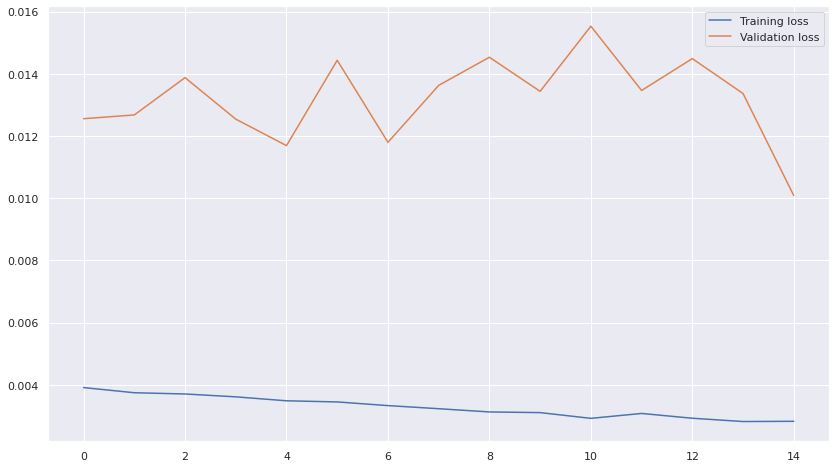

In [18]:
# evaluating model with loss graph
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

286/286 [==============================] - 1s 2ms/step


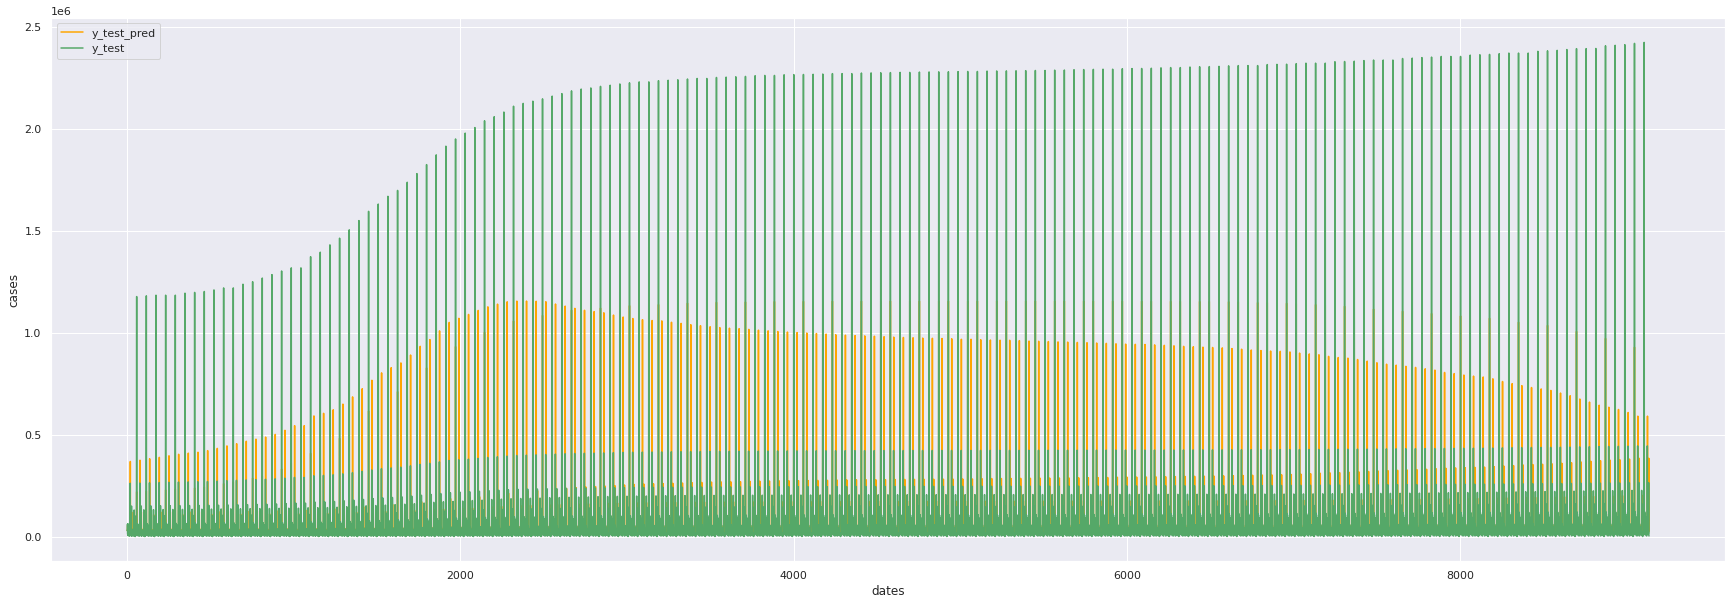

In [19]:
# get predictions
y_train_pred = scaler.inverse_transform(sr_model.predict(X_train))
y_test_pred = scaler.inverse_transform(sr_model.predict(X_test)) 

y_train = scaler.inverse_transform(y_train) 

# visualize predictions
plt.figure(figsize = (30,10))
plt.plot(y_test_pred, label = "y_test_pred", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("dates")
plt.ylabel("cases")
plt.legend()
plt.show()

**Part 2: Implementing RNN with LSTM/GRU**

In [20]:
# initialize necessary params
train_size = round(df.shape[0] * .8)  
test_size = df.shape[0] - train_size
scaler = MinMaxScaler(feature_range = (0,1))

# get training data
X_train, y_train = prep(train_size, 1, df[:train_size].iloc[:,:3]) #train
print("Shape of X_train : ",X_train.shape)
print("Shape of y_train : ",y_train.shape)

# get testing data
X_test, y_test = prep(test_size, 1, df[train_size:].iloc[:,:3]) #test
print("\nShape of X_train : ",X_test.shape)
print("Shape of y_train : ",y_test.shape)

Shape of X_train :  (36545, 1, 1)
Shape of y_train :  (36545, 1)

Shape of X_train :  (9135, 1, 1)
Shape of y_train :  (9135, 1)


In [21]:
# create LSTM model
lstm_model = make_rnn(X_train, y_train, 2)
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 87,201
Trainable params: 87,201
Non-trainable params: 0
_________________________________________________________________


In [22]:
# fitting LSTM RNN model
history = lstm_model.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2, verbose=2)

Epoch 1/15
293/293 - 6s - loss: 0.0043 - val_loss: 0.0142 - 6s/epoch - 20ms/step
Epoch 2/15
293/293 - 3s - loss: 0.0038 - val_loss: 0.0125 - 3s/epoch - 10ms/step
Epoch 3/15
293/293 - 3s - loss: 0.0037 - val_loss: 0.0122 - 3s/epoch - 9ms/step
Epoch 4/15
293/293 - 2s - loss: 0.0036 - val_loss: 0.0123 - 2s/epoch - 8ms/step
Epoch 5/15
293/293 - 2s - loss: 0.0036 - val_loss: 0.0125 - 2s/epoch - 8ms/step
Epoch 6/15
293/293 - 3s - loss: 0.0035 - val_loss: 0.0125 - 3s/epoch - 9ms/step
Epoch 7/15
293/293 - 2s - loss: 0.0034 - val_loss: 0.0115 - 2s/epoch - 7ms/step
Epoch 8/15
293/293 - 2s - loss: 0.0033 - val_loss: 0.0147 - 2s/epoch - 8ms/step
Epoch 9/15
293/293 - 3s - loss: 0.0032 - val_loss: 0.0149 - 3s/epoch - 9ms/step
Epoch 10/15
293/293 - 2s - loss: 0.0031 - val_loss: 0.0129 - 2s/epoch - 8ms/step
Epoch 11/15
293/293 - 2s - loss: 0.0030 - val_loss: 0.0135 - 2s/epoch - 7ms/step
Epoch 12/15
293/293 - 3s - loss: 0.0029 - val_loss: 0.0132 - 3s/epoch - 9ms/step
Epoch 13/15
293/293 - 5s - loss: 0.

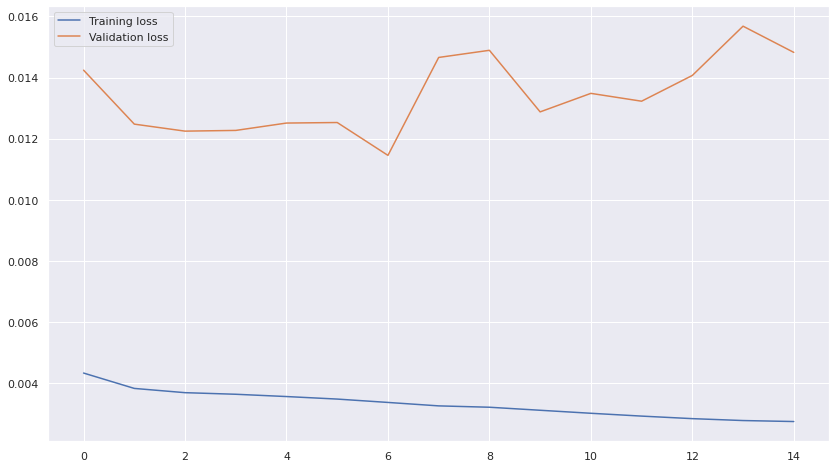

In [23]:
# evaluating model with loss graph
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

286/286 [==============================] - 1s 3ms/step


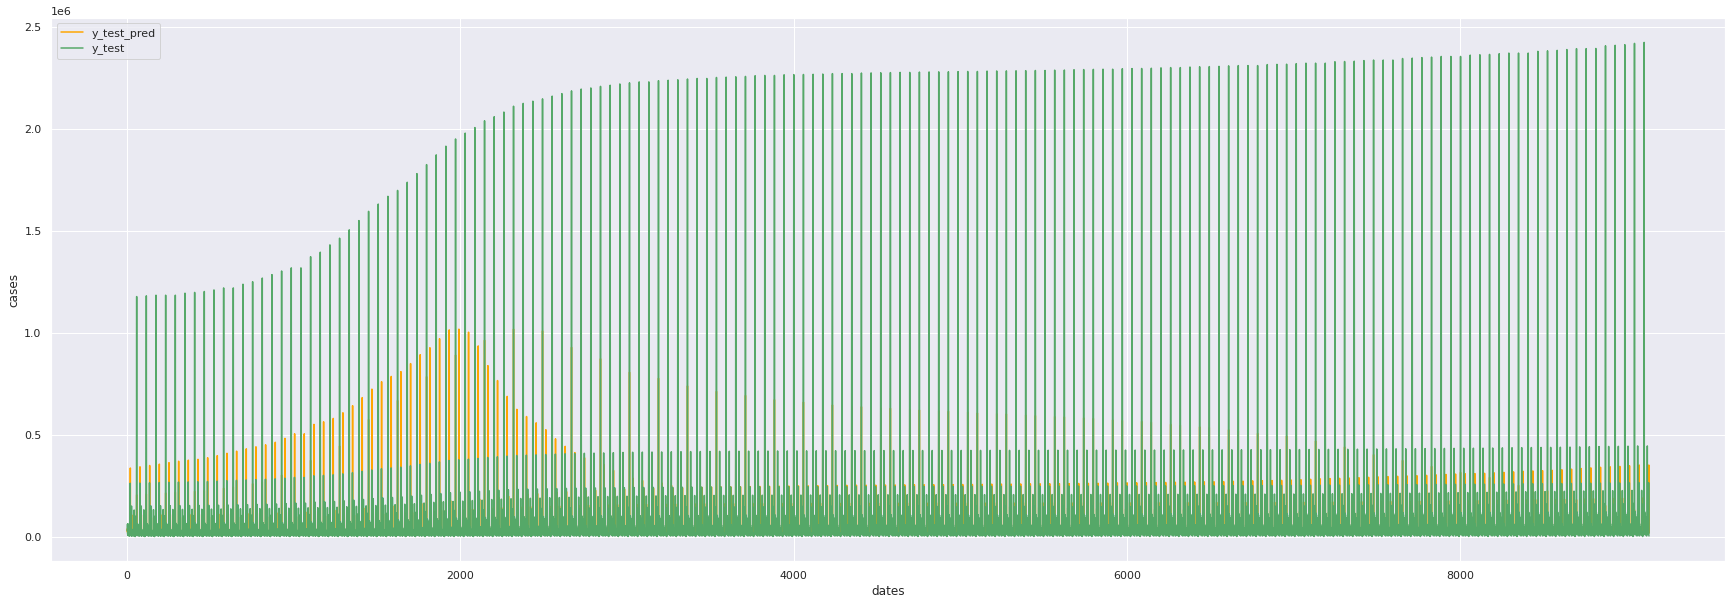

In [24]:
# get predictions
y_train_pred = scaler.inverse_transform(lstm_model.predict(X_train))
y_test_pred = scaler.inverse_transform(lstm_model.predict(X_test)) 

y_train = scaler.inverse_transform(y_train) 

# visualize predictions
plt.figure(figsize = (30,10))
plt.plot(y_test_pred, label = "y_test_pred", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("dates")
plt.ylabel("cases")
plt.legend()
plt.show()

In [25]:
# create GRU model
gru_model = make_rnn(X_train, y_train, 3)
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 128)            50304     
                                                                 
 gru_1 (GRU)                 (None, 32)                15552     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 65,889
Trainable params: 65,889
Non-trainable params: 0
_________________________________________________________________


In [26]:
# fitting GRU RNN model
history = gru_model.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2, verbose=2)

Epoch 1/15
293/293 - 6s - loss: 27493783552.0000 - val_loss: 97558913024.0000 - 6s/epoch - 19ms/step
Epoch 2/15
293/293 - 2s - loss: 27458301952.0000 - val_loss: 97371537408.0000 - 2s/epoch - 8ms/step
Epoch 3/15
293/293 - 2s - loss: 27326482432.0000 - val_loss: 96898752512.0000 - 2s/epoch - 7ms/step
Epoch 4/15
293/293 - 2s - loss: 27087122432.0000 - val_loss: 96168689664.0000 - 2s/epoch - 7ms/step
Epoch 5/15
293/293 - 2s - loss: 26788591616.0000 - val_loss: 95264030720.0000 - 2s/epoch - 8ms/step
Epoch 6/15
293/293 - 2s - loss: 26507980800.0000 - val_loss: 94371856384.0000 - 2s/epoch - 7ms/step
Epoch 7/15
293/293 - 2s - loss: 26288220160.0000 - val_loss: 93601153024.0000 - 2s/epoch - 7ms/step
Epoch 8/15
293/293 - 2s - loss: 26178578432.0000 - val_loss: 93055934464.0000 - 2s/epoch - 7ms/step
Epoch 9/15
293/293 - 2s - loss: 26111047680.0000 - val_loss: 92678307840.0000 - 2s/epoch - 7ms/step
Epoch 10/15
293/293 - 4s - loss: 26098659328.0000 - val_loss: 92484280320.0000 - 4s/epoch - 12ms/st

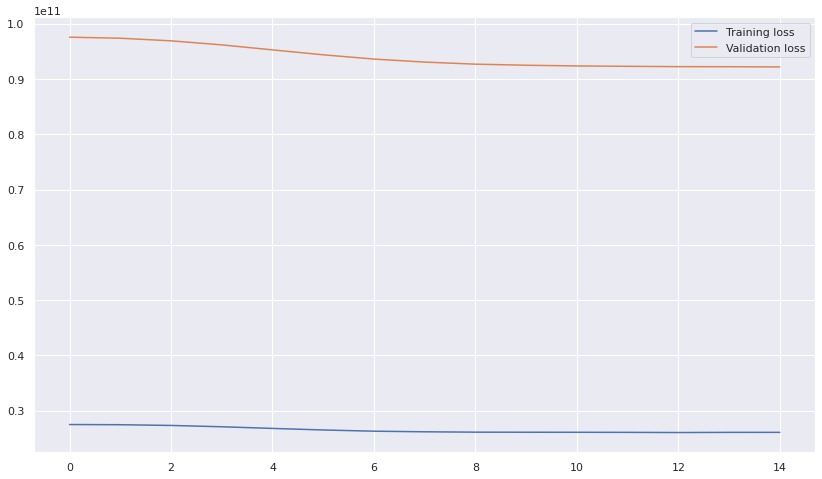

In [27]:
# evaluating model with loss graph
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

286/286 [==============================] - 1s 2ms/step


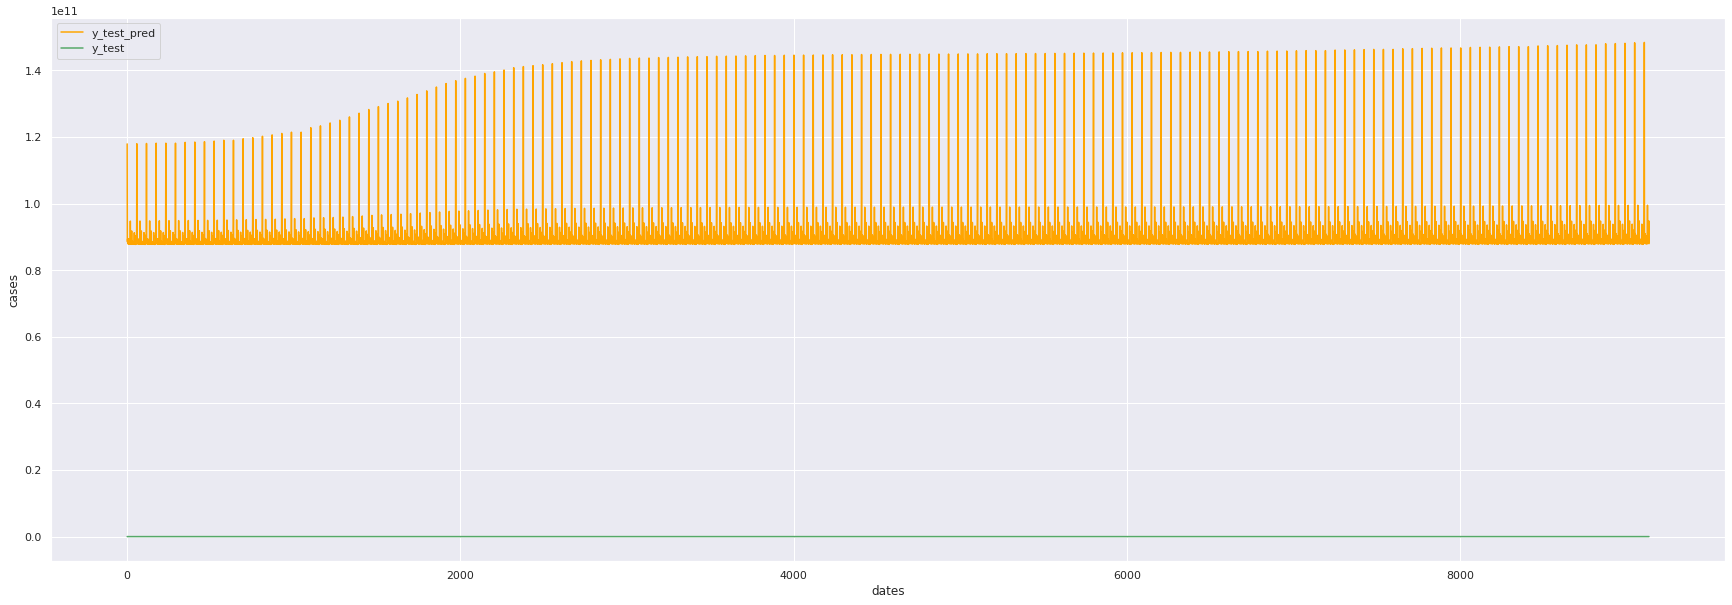

In [28]:
# get predictions
y_train_pred = scaler.inverse_transform(gru_model.predict(X_train))
y_test_pred = scaler.inverse_transform(gru_model.predict(X_test)) 

y_train = scaler.inverse_transform(y_train) 

# visualize predictions
plt.figure(figsize = (30,10))
plt.plot(y_test_pred, label = "y_test_pred", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("dates")
plt.ylabel("cases")
plt.legend()
plt.show()

There doesn't seem to be that much of a difference in the results for the simple RNN and the LSTM. GRU, on the other hand, has a decently different result. Maybe the data has a very obvious trend, and that is why there didn't seem to be any improvement when LSTM. For GRU however, I am not sure why it had such a different result.